# STARDIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.io.atom_data import AtomData

from astropy import units as u, constants as const

from stardis.io import read_marcs_to_fv
from stardis.plasma import create_splasma
from stardis.opacities import calc_tau_h_minus, calc_tau_e, calc_tau_line, calc_tau_photo
from stardis.raytrace import bb_nu, bb_lambda, raytrace

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

## Sun Spectrum

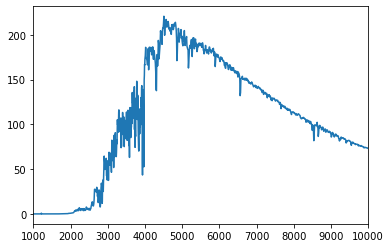

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(1000, 10000);

## Model & Atomic Data

In [3]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
marcs_model_fv, marcs_abundances_all, boundary_temps = read_marcs_to_fv('data/marcs/sun.mod', adata, 30)
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Wavelengths and Frequencies

In [4]:
tracing_lambdas = np.arange(1000, 10000, 1) * u.Angstrom
tracing_nus = tracing_lambdas.to(u.Hz, u.spectral())

## Plasma

In [5]:
splasma = create_splasma(marcs_model_fv, marcs_abundances_all, adata)

## Optical Depths

In [6]:
tau_line = calc_tau_line(splasma, marcs_model_fv, tracing_nus)

In [7]:
tau_h_minus = calc_tau_h_minus(
    splasma,
    marcs_model_fv,
    tracing_nus,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
)

In [8]:
tau_e = calc_tau_e(splasma, marcs_model_fv, tracing_nus)

In [9]:
tau_photo_H = ( calc_tau_photo(splasma, marcs_model_fv, tracing_nus, (1,0,1), 7.91e-18, 8.22e14)
               + calc_tau_photo(splasma, marcs_model_fv, tracing_nus, (1,0,2), 7.91e-18, 8.22e14)
               + calc_tau_photo(splasma, marcs_model_fv, tracing_nus, (1,0,3), 7.91e-18, 8.22e14) )

In [10]:
all_taus = [tau_line, tau_h_minus, tau_e, tau_photo_H]

## Source Function

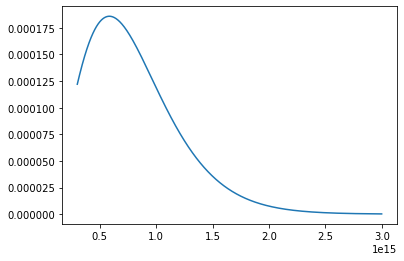

In [11]:
bb = bb_nu(tracing_nus, boundary_temps)
plt.plot(tracing_nus, bb[0]);

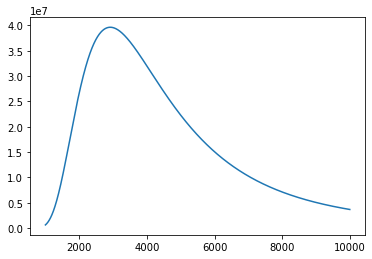

In [12]:
bbw = bb_lambda(tracing_lambdas, boundary_temps)
plt.plot(tracing_lambdas, bbw[0]);

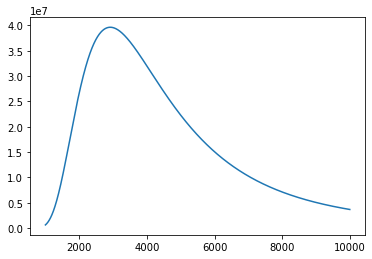

In [13]:
bbw_test = bb*tracing_nus/tracing_lambdas
plt.plot(tracing_lambdas, bbw_test[0]);

## Ray tracing

In [14]:
I_nu = raytrace(bb, all_taus, tracing_nus, len(marcs_model_fv))

## Plotting

In [15]:
I_lambda = I_nu[55] * tracing_nus/tracing_lambdas

# R_sun/r_sun-to-earth = 0.00458
intensity_to_flux = np.pi * 0.00458**2

F_lambda = intensity_to_flux * I_lambda

smooth_F_lambda = ndimage.gaussian_filter1d(F_lambda, 5)

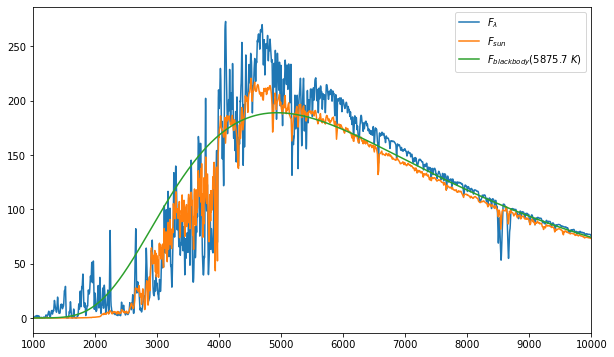

In [16]:
#%matplotlib notebook

plt.figure(figsize=(10,6))
plt.plot(tracing_lambdas, smooth_F_lambda, label="$F_\lambda$")
plt.plot(sun_spec.wave, sun_spec.flux, label="$F_{sun}$")
bb_index = 17
plt.plot(tracing_lambdas, intensity_to_flux * bbw[bb_index], label="$F_{blackbody}"+f"({boundary_temps[bb_index][0]}\ K)$")

plt.xlim((1000,10000))
plt.legend();